# Histopathologic Cancer Detection (Mini Project)

## The Problem and Data

This is a project about building a model to identify metastatic cancer in small image patches taken from larger digital pathology scans.

The training dataset consists of a set of pathology images in .tif format named with an image `id`, and a csv file `train_labels.csv` containing the `id`s and the corresponding label (1/0). A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue.  According to the competition main page, the dataset is a slightly modified version of the PatchCamelyon (PCam) [benchmark dataset](https://github.com/basveeling/pcam). The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates.

Keras will be used to train CNN models. VGG-style architecture will be used. The model with the best training performance will be used to make prediction on the test dataset for the final submission.

The goal of this mini project is to experience Keras and CNN. Given the limited time, only limited iterations & optimizations will be performed.

## Environment Setup, EDA, and Data Preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import keras
import matplotlib.pyplot as plt
from tifffile import imread
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [2]:
dir_images_train = "../input/histopathologic-cancer-detection/train/"
images_train = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")
images_train["label"] = images_train["label"].astype(str)
images_train["filename"] = images_train['id'] + ".tif"
images_train = images_train[["filename", "label"]]

print(images_train.head(), "\n")
print(images_train.info())

                                       filename label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  220025 non-null  object
 1   label     220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None


[Text(0, 0, '130908'), Text(0, 0, '89117')]

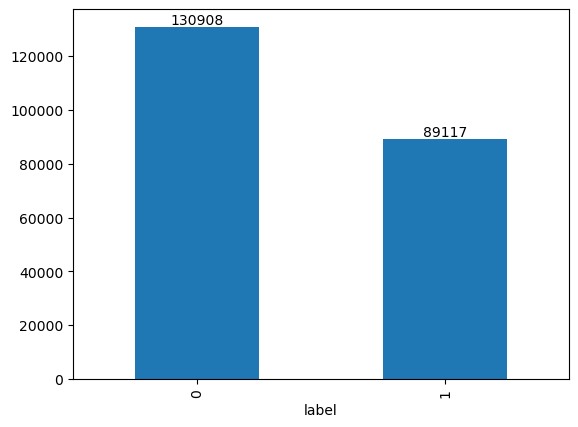

In [3]:
p = images_train.groupby("label")["label"].count().plot(kind="bar")
p.bar_label(p.containers[0])

There are **220025** images in the training set, with around 60% negative cases.

Below are a few examples of the images in the training set.

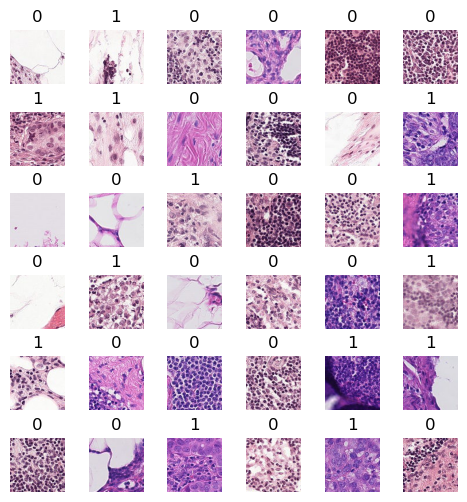

(96, 96, 3)


In [4]:
rows, cols = 6, 6

fig, axes = plt.subplots(rows, cols, figsize=(6, 6))

for i in range(6 * 6):
    image = imread(dir_images_train + images_train["filename"][i])
    
    row, col = i // cols, i % cols

    axes[row, col].imshow(image)
    axes[row, col].axis("off")
    axes[row, col].set_title(images_train["label"][i])

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()

print(image.shape)

Training set will be split into training and validation set with a 7:3 ratio.

In [5]:
batch_size = 128
random_seed = 100

idg = ImageDataGenerator(rescale=1./255, validation_split=0.3)

data_train = idg.flow_from_dataframe(
    dataframe=images_train,
    x_col="filename",
    y_col="label",
    directory=dir_images_train,
    subset="training",
    class_mode="binary",
    batch_size=batch_size,
    target_size=(96, 96),
    seed=random_seed)

data_validate = idg.flow_from_dataframe(
    dataframe=images_train,
    x_col="filename",
    y_col="label",
    directory=dir_images_train,
    subset="validation",
    class_mode="binary",
    batch_size=batch_size,
    target_size=(96, 96),
    seed=random_seed)

Found 154018 validated image filenames belonging to 2 classes.
Found 66007 validated image filenames belonging to 2 classes.


## Model Building and Training

### The first model

To start with, a model with **(Conv2D → Conv2D → MaxPool2D)*3** architecture will be built and trained. ReLU and sigmoid will be used as the activation function for the hidden layers and output layer. Adam optimizer will be used to train the model with 5 epochs.

In [6]:
model1 = Sequential(name="model1")

model1.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model1.add(Conv2D(filters=16, kernel_size=(3,3), activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model1.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model1.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(units=128))
model1.add(BatchNormalization())
model1.add(Activation("relu"))
model1.add(Dense(units=1, activation="sigmoid"))

model1.build(input_shape=(batch_size,96,96,3))

model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (128, 94, 94, 16)         448       
                                                                 
 conv2d_1 (Conv2D)           (128, 92, 92, 16)         2320      
                                                                 
 max_pooling2d (MaxPooling2D  (128, 46, 46, 16)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (128, 44, 44, 32)         4640      
                                                                 
 conv2d_3 (Conv2D)           (128, 42, 42, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 21, 21, 32)        0         
 2D)                                                        

In [7]:
learning_rate = 0.0001
epochs = 5

opt = Adam(learning_rate=learning_rate)
model1.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
hist1 = model1.fit(data_train, validation_data=data_validate, epochs=epochs, batch_size=batch_size)

Epoch 1/5
1204/1204 [==============================] - 1947s 2s/step - loss: 0.4175 - accuracy: 0.8119 - val_loss: 0.4758 - val_accuracy: 0.7754
Epoch 2/5
1204/1204 [==============================] - 690s 573ms/step - loss: 0.3534 - accuracy: 0.8466 - val_loss: 0.3630 - val_accuracy: 0.8405
Epoch 3/5
1204/1204 [==============================] - 405s 337ms/step - loss: 0.3203 - accuracy: 0.8630 - val_loss: 0.3903 - val_accuracy: 0.8221
Epoch 4/5
1204/1204 [==============================] - 354s 294ms/step - loss: 0.2976 - accuracy: 0.8738 - val_loss: 0.4010 - val_accuracy: 0.8228
Epoch 5/5
1204/1204 [==============================] - 356s 296ms/step - loss: 0.2742 - accuracy: 0.8851 - val_loss: 0.3358 - val_accuracy: 0.8586


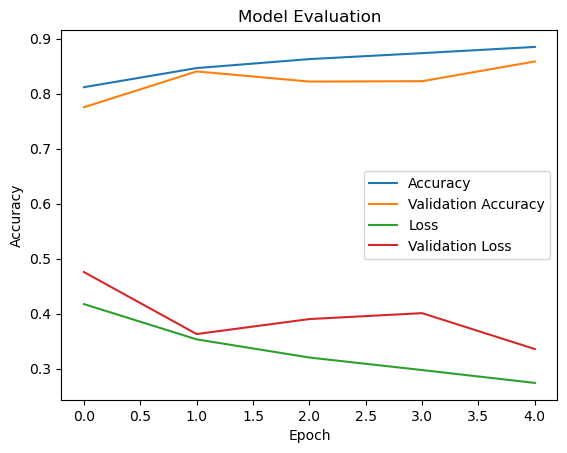

In [8]:
plt.plot(hist1.history["accuracy"])
plt.plot(hist1.history["val_accuracy"])
plt.plot(hist1.history["loss"])
plt.plot(hist1.history["val_loss"])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

The tarining & validation accuracy after 5 epochs is **0.8851** and **0.8586**. Notice that the model achieved its best validation performance after the last epoch. It is possible to further improve the accuracy with more epochs.

### Attempt to improve performance with batch normalization

Next, let's try to add a batch normalization layer after each convolutional layer and the dense layer.

Batch normalization is a technique to improve the model performance by normalizing (subtracting the mean and dividing by the standard deviation) the output of its previous layer. In general, batch normalization can help to improve the accuracy and reduce overfitting of the model. It can also help to stabilize the gradients that flow through the network and prevent the vanishing or exploding gradient problem.

In [9]:
model2 = Sequential(name="model2")

model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(filters=64, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPool2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(units=128))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dense(units=1, activation="sigmoid"))

model2.build(input_shape=(batch_size,96,96,3))

model2.summary()

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (128, 94, 94, 16)         448       
                                                                 
 batch_normalization_1 (Batc  (128, 94, 94, 16)        64        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (128, 94, 94, 16)         0         
                                                                 
 conv2d_7 (Conv2D)           (128, 92, 92, 16)         2320      
                                                                 
 batch_normalization_2 (Batc  (128, 92, 92, 16)        64        
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (128, 92, 92, 16)         0    

In [10]:
model2.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
hist2 = model2.fit(data_train, validation_data=data_validate, epochs=epochs, batch_size=batch_size)

Epoch 1/5
1204/1204 [==============================] - 341s 282ms/step - loss: 0.3519 - accuracy: 0.8483 - val_loss: 0.3358 - val_accuracy: 0.8551
Epoch 2/5
1204/1204 [==============================] - 332s 276ms/step - loss: 0.2892 - accuracy: 0.8796 - val_loss: 0.2896 - val_accuracy: 0.8801
Epoch 3/5
1204/1204 [==============================] - 349s 290ms/step - loss: 0.2582 - accuracy: 0.8940 - val_loss: 0.2686 - val_accuracy: 0.8894
Epoch 4/5
1204/1204 [==============================] - 376s 313ms/step - loss: 0.2328 - accuracy: 0.9055 - val_loss: 0.3627 - val_accuracy: 0.8472
Epoch 5/5
1204/1204 [==============================] - 344s 286ms/step - loss: 0.2112 - accuracy: 0.9149 - val_loss: 0.2779 - val_accuracy: 0.8865


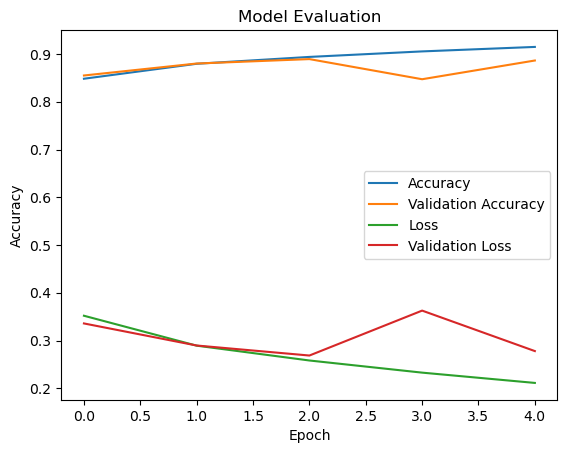

In [11]:
plt.plot(hist2.history["accuracy"])
plt.plot(hist2.history["val_accuracy"])
plt.plot(hist2.history["loss"])
plt.plot(hist2.history["val_loss"])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

The tarining & validation accuracy after 5 epochs is **0.9149** and **0.8865**, which are higher than the initial model. Notice the best validation performance was achieved after the 3rd epoch. More epochs will be needed to confirm if the training has converged.

## Conclusion

| Accuracy after 5 epochs | Initial model | With batch normalization |
| --- | --- | --- | 
| Training | 0.8851 | 0.9149 |
| Validation | 0.8586 | 0.8865 |

The simple VGG-style model was shown to provide a fairly good performance for this type of image classification problems. Batch normalization further improved the accuracy.

Some potential ways to improve the performance including:
* Training with more epochs
* Tuning the model architecture & hyperparameters
* Trying out other optimizer

## Submission

In [12]:
dir_images_test = "../input/histopathologic-cancer-detection/test/"
images_test = pd.DataFrame({"filename":os.listdir(dir_images_test)})

generator_test = ImageDataGenerator(rescale=1./255)

data_test = generator_test.flow_from_dataframe(
    dataframe=images_test,
    x_col="filename",
    directory=dir_images_test,
    class_mode=None,
    batch_size=1,
    target_size=(96, 96),
    shuffle=False)

Found 57458 validated image filenames.


In [13]:
predictions = model2.predict(data_test, verbose=1)
print(predictions)

57458/57458 [==============================] - 511s 9ms/step
[[0.6800818 ]
 [0.05940943]
 [0.01226757]
 ...
 [0.8167343 ]
 [0.0731182 ]
 [0.25297496]]


In [14]:
predictions_t = np.transpose(predictions)[0]

submission_df = pd.DataFrame()
submission_df["id"] = images_test["filename"].apply(lambda x: x.split(".")[0])
submission_df["label"] = list(map(lambda x: 0 if x < 0.5 else 1, predictions_t))

submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [15]:
submission_df.to_csv("submission.csv", index=False)